In [298]:
import torch
import numpy as np

In [299]:
  # Muller-Brown potential
def compute_Muller_potential(scale, x):
    A = (-200.0, -100.0, -170.0, 15.0)
    beta = (0.0, 0.0, 11.0, 0.6)
    alpha_gamma = (
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-1.0, -10.0]),
        x.new_tensor([-6.5, -6.5]),
        x.new_tensor([0.7, 0.7]),
    )
    ab = (
        x.new_tensor([1.0, 0.0]),
        x.new_tensor([0.0, 0.5]),
        x.new_tensor([-0.5, 1.5]),
        x.new_tensor([-1.0, 1.0]),
    )
    U = 0
    for i in range(4):
        diff = x - ab[i]
        U = U + A[i] * torch.exp(
            torch.sum(alpha_gamma[i] * diff**2, -1) + beta[i] * torch.prod(diff, -1)
        )
    U = scale * U
    return U

def compute_gradient(scale, x):
    # Function to compute the gradient of the Müller-Brown potential
    U = compute_Muller_potential(scale, x)
    grad_U = torch.autograd.grad(U, x, create_graph=True)[0]
    return grad_U

def gibbs_sampling_with_potential(scale, num_samples, step_size=0.5):
    samples = np.zeros((num_samples, 2))
    x = np.random.normal(0, 1, 2)  # Initial guess for x and y
    x_tensor = torch.tensor(x, dtype=torch.float32)
    U_x = compute_Muller_potential(scale, x_tensor)

    for i in range(num_samples):
        # Sample y from the conditional distribution of y | x
        y = np.random.normal(x[1], step_size)
        x_y = np.array([x[0], y])
        x_y_tensor = torch.tensor(x_y, dtype=torch.float32)
        U_x_y = compute_Muller_potential(scale, x_y_tensor)

        # Accept or reject the new y based on the potential
        if np.exp(U_x - U_x_y) > np.random.rand():
            x[1] = y
            U_x = U_x_y

        # Sample x from the conditional distribution of x | y
        x_new = np.random.normal(x[0], step_size)
        y_x = np.array([x_new, x[1]])
        y_x_tensor = torch.tensor(y_x, dtype=torch.float32)
        U_y_x = compute_Muller_potential(scale, y_x_tensor)

        # Accept or reject the new x based on the potential
        if np.exp(U_x_y - U_y_x) > np.random.rand():
            x[0] = x_new
            U_x = U_y_x

        samples[i] = x

    return samples

# Defining the target PDF based on the Müller-Brown potential
def target_pdf_muller_brown(x, scale=1.0, temperature=1.0):
    potential = compute_Muller_potential(scale, x)
    return torch.exp(-potential / temperature)

# Proposal distribution function: Gaussian centered at the current parameter
def proposal_dist_gaussian(current_param, std_dev=0.1):
    proposed_param = current_param + torch.randn_like(current_param) * std_dev
    return proposed_param

# Metropolis-Hastings algorithm adapted for the Müller-Brown potential
def metropolis_hastings_muller_brown(target_pdf, proposal_dist, initial_param, iterations, temperature=40.0, scale=1.0):
    current_param = initial_param
    samples = [current_param.numpy()]
    for _ in range(iterations):
        proposed_param = proposal_dist(current_param)
        acceptance_probability = min(
            1,
            (target_pdf(proposed_param, scale, temperature) / target_pdf(current_param, scale, temperature)).item()
        )
        if torch.rand(1).item() < acceptance_probability:
            current_param = proposed_param
        samples.append(current_param.numpy())
    return np.array(samples)
    
def kl_divergence(p, q):
    # Adding a small constant for smoothing
    epsilon = 1e-10
    p_smoothed = p + epsilon
    q_smoothed = q + epsilon
    return np.sum(np.where(p_smoothed != 0, p_smoothed * np.log(p_smoothed / q_smoothed), 0))

def generate_grid(x1_min, x1_max, x2_min, x2_max, size=100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim=-1)
    x = grid.reshape((-1, 2))
    return x

In [300]:
# Parameters
initial_param = torch.tensor(np.array([np.random.uniform(-1.5, 1.0), np.random.uniform(-0.5, 2)]), dtype=torch.float32)
num_samples = 10000
scale = 1.0
grid_size = 100

# Generate samples from both methods
# Perform Gibbs sampling with the Muller-Brown potential
gibbs_samples = gibbs_sampling_with_potential(scale, num_samples)
metropolis_samples = metropolis_hastings_muller_brown(target_pdf_muller_brown, proposal_dist_gaussian, initial_param, num_samples)

/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_53682/220597795.py:46: RuntimeWarning: overflow encountered in exp
  if np.exp(U_x - U_x_y) > np.random.rand():
/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_53682/220597795.py:57: RuntimeWarning: overflow encountered in exp
  if np.exp(U_x_y - U_y_x) > np.random.rand():


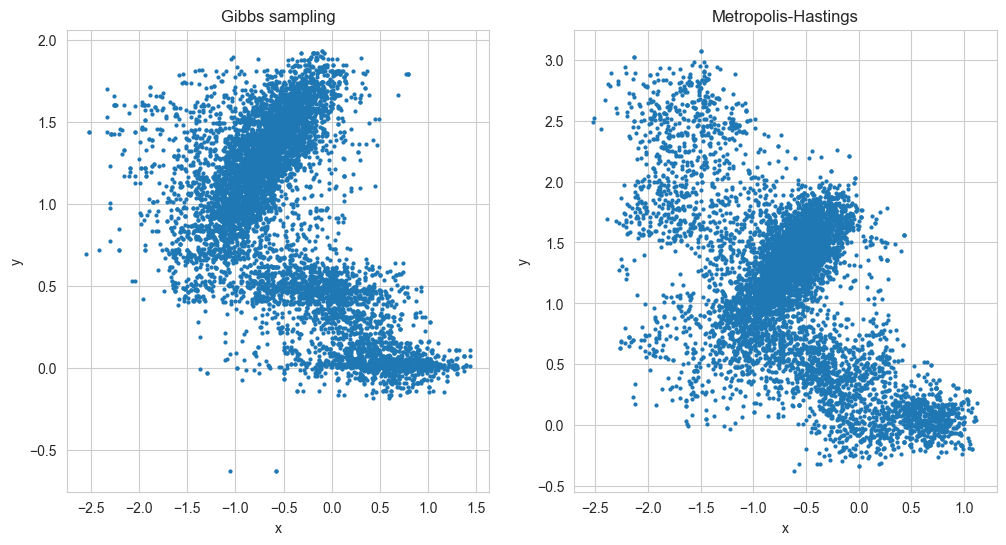

In [301]:
# Plot gibbs samples
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(gibbs_samples[:, 0], gibbs_samples[:, 1], "o", markersize=2)
plt.title("Gibbs sampling")
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
plt.plot(metropolis_samples[:, 0], metropolis_samples[:, 1], "o", markersize=2)
plt.title("Metropolis-Hastings")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


[[-0.58341703 -0.62602774]
 [-0.58341703 -0.62602774]
 [-1.05579375 -0.62602774]
 ...
 [-0.39567264  1.35566337]
 [-0.39567264  1.35566337]
 [-0.23812786  1.35566337]]


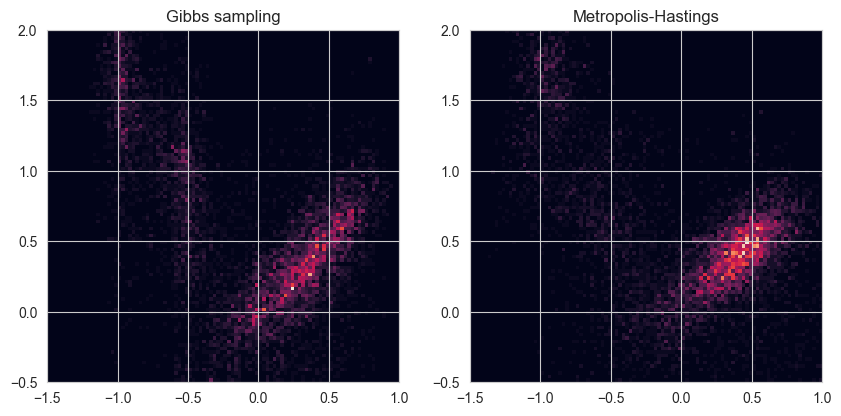

In [302]:
# Create 2D histograms for the samples
hist_gibbs, _, _ = np.histogram2d(gibbs_samples[:, 0], gibbs_samples[:, 1], bins=grid_size, range=[[-1.5, 1], [-0.5,2]])
hist_metropolis, _, _ = np.histogram2d(metropolis_samples[:, 0], metropolis_samples[:, 1], bins=grid_size, range=[[-1.5,1], [-0.5, 2]])
print(gibbs_samples)
# Plot the histograms
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(hist_gibbs, origin="lower", extent=[-1.5, 1, -0.5, 2])
ax[0].set_title("Gibbs sampling")
ax[1].imshow(hist_metropolis, origin="lower", extent=[-1.5, 1, -0.5, 2])
ax[1].set_title("Metropolis-Hastings")
plt.show()


In [303]:
# Normalize to create probability distributions
prob_gibbs = hist_gibbs / np.sum(hist_gibbs)
prob_metropolis = hist_metropolis / np.sum(hist_metropolis)

In [304]:
# Compute the theoretical distribution
x_grid = generate_grid(-1.5, 1, -0.5, 2, grid_size)
U = compute_Muller_potential(scale, x_grid).reshape(grid_size, grid_size)

U = U.numpy()
# Normalize U (we are only interested in the shape of the distribution  
U[U > 100] = 100
U /= U.max()

prob_theoretical = np.exp(-U)
prob_theoretical /= np.sum(prob_theoretical)

print(prob_theoretical.shape, prob_theoretical.min(), prob_theoretical.max())
print(prob_gibbs.shape, prob_gibbs.min(), prob_gibbs.max())
print(prob_metropolis.shape, prob_metropolis.min(), prob_metropolis.max())


(100, 100) 3.0661093e-05 0.00036101489
(100, 100) 0.0 0.003663770543284832
(100, 100) 0.0 0.0036540803897685747


In [305]:
# Compute KL divergence for both methods
kl_gibbs = kl_divergence(prob_gibbs, prob_theoretical)
kl_metropolis = kl_divergence(prob_metropolis, prob_theoretical)

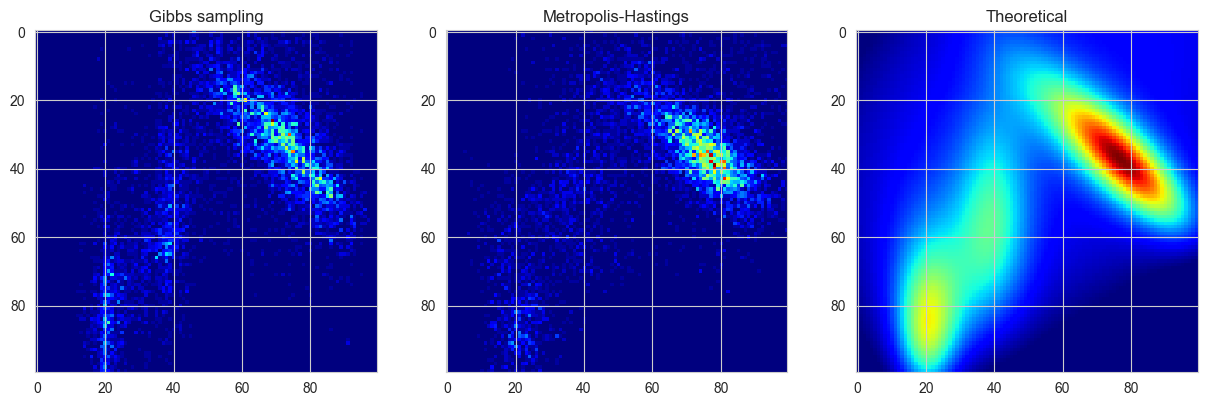

In [306]:
# Plot the prob_gibbs, prob_metropolis, and prob_theoretical as heatmaps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(prob_gibbs, cmap="jet")
ax[0].set_title("Gibbs sampling")
ax[1].imshow(prob_metropolis, cmap="jet")
ax[1].set_title("Metropolis-Hastings")
ax[2].imshow(prob_theoretical, cmap="jet")
ax[2].set_title("Theoretical")
plt.show()


In [307]:
print(kl_gibbs, kl_metropolis)

0.9564874159879316 1.0191564053846989


In [314]:
# Plot the convergence of the KL divergence when increasing the n_samples of each method

# Parameters
initial_param = torch.tensor(np.array([np.random.uniform(-1.5, 1.0), np.random.uniform(-0.5, 2)]), dtype=torch.float32)
num_samples_max = 10000
scale = 1.0
grid_size = 100

# Generate samples from both methods
# Perform Gibbs sampling with the Muller-Brown potential

gibbs_kls = []
metropolis_kls = []

gibbs_samples = gibbs_sampling_with_potential(scale, num_samples_max)
metropolis_samples = metropolis_hastings_muller_brown(target_pdf_muller_brown, proposal_dist_gaussian, initial_param, num_samples_max, temperature=40.0)


/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_53682/220597795.py:57: RuntimeWarning: overflow encountered in exp
  if np.exp(U_x_y - U_y_x) > np.random.rand():
/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_53682/220597795.py:46: RuntimeWarning: overflow encountered in exp
  if np.exp(U_x - U_x_y) > np.random.rand():


In [315]:
for n in range(1, num_samples_max):
    # Create 2D histograms for the samples
    hist_gibbs, _, _ = np.histogram2d(gibbs_samples[:n, 0], gibbs_samples[:n, 1], bins=grid_size, range=[[-2, 1], [-0.5,2]])
    hist_metropolis, _, _ = np.histogram2d(metropolis_samples[:n, 0], metropolis_samples[:n, 1], bins=grid_size, range=[[-2,1], [-0.5, 2]])
    
    # Normalize to create probability distributions
    prob_gibbs = hist_gibbs / np.sum(hist_gibbs)
    prob_metropolis = hist_metropolis / np.sum(hist_metropolis)
    
    # Compute KL divergence for both methods
    gibbs_kls.append(kl_divergence(prob_gibbs, prob_theoretical))
    metropolis_kls.append(kl_divergence(prob_metropolis, prob_theoretical))

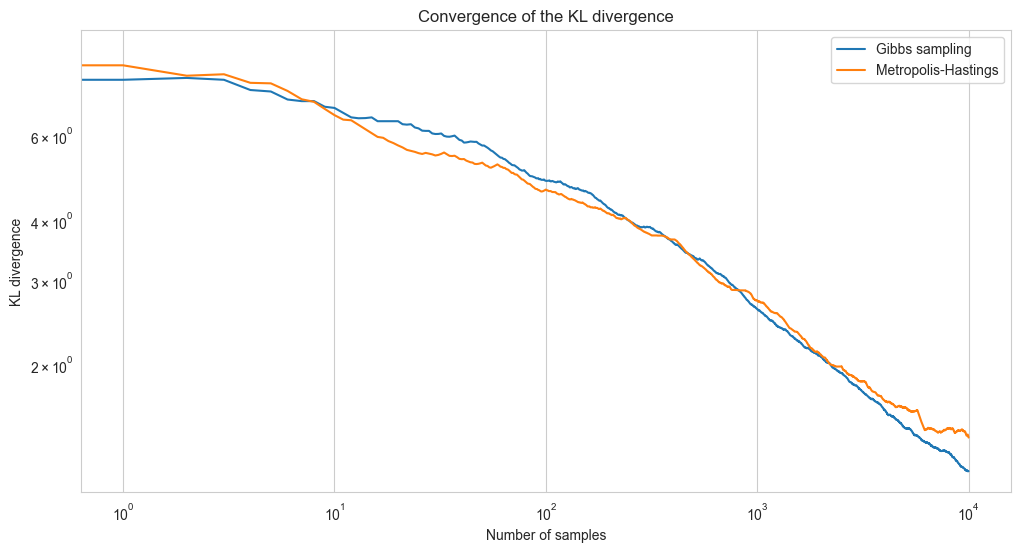

In [317]:
# Plot the arrays gibbs_kls and metropolis_kls
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.loglog(gibbs_kls, label="Gibbs sampling")
plt.loglog(metropolis_kls, label="Metropolis-Hastings")
plt.legend()
plt.xlabel("Number of samples")
plt.ylabel("KL divergence")
plt.title("Convergence of the KL divergence")
plt.show()